# Regression on biodiversity index

We are going to test different models on our dataset, trying to get a better results using a grid search and the testing the models on a dataset of a different region.

For each model we're going to use a RandomizedSearchCV to narrow our parameters research and the the GridSearchCV to find the best one.

In [32]:
import pandas as pd
import numpy as np
import glob
import os
import sys
import torch

import matplotlib.pyplot  as plt 
from itertools import combinations 
from typing import Dict, Any
from scipy.stats import uniform, randint
from sklearn.decomposition import PCA

from sklearn import preprocessing

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

import xgboost as xgb

module_this = os.path.abspath(os.path.join(os.getcwd()))
modules = [ module_this]

for module in modules:
    if module not in sys.path:
        sys.path.append(module)

import utils as ut

## Load Datasets

In [33]:
folder = "../Dataset"
regression_label = 'habitat_richness'
test_size = 0.2
#swi_labels = ['SWI1km-SWI-002', 'SWI1km-SWI-100', 'SWI1km-SWI-040', 'SWI1km-SWI-005', 
#              'SWI1km-SWI-010', 'SWI1km-SWI-060', 'SWI1km-SWI-015', 'SWI1km-SWI-020']

datas = []

paths = [f for f in glob.glob(folder + "/*.csv") if 'out_closest_point_mean' in f]
paths += [f for f in glob.glob(folder + "/*.csv") if 'out_knn' in f]
paths += [f for f in glob.glob(folder + "/*.csv") if 'out_mean' in f]
paths += [f for f in glob.glob(folder + "/*.csv") if 'out_remove' in f]

for path in paths:
    df = pd.read_csv(path, index_col=['longitude', 'latitude'])

    if(df.isna().any().any()):
        print(path, '\t has ', df.isna().any().sum(), ' row with null values')
    
    y = df[regression_label].values
    X = df.drop(columns=[regression_label]).values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)
    datas.append({'name': path[11:-4], 'dataframe': df, 'y': y, 'X': X, 
                'X_train': X_train, 'X_test': X_test, 
            'y_train': y_train, 'y_test': y_test})

In [3]:
for x in datas:
    print(x['name'], "\t--\t",x['dataframe'].shape)

bulgaria_out_closest_point_mean_handle_custom_set 	--	 (14458, 47)
finland_out_closest_point_mean_handle_custom_set 	--	 (17714, 47)
france_out_closest_point_mean_handle_custom_set 	--	 (1882, 47)
italy_out_closest_point_mean_handle_custom_set 	--	 (17387, 47)
bulgaria_out_knn_handle_custom_set 	--	 (14458, 47)
finland_out_knn_handle_custom_set 	--	 (17714, 47)
france_out_knn_handle_custom_set 	--	 (1882, 47)
italy_out_knn_handle_custom_set 	--	 (17387, 47)
bulgaria_out_mean_handle_custom_set 	--	 (14458, 47)
finland_out_mean_handle_custom_set 	--	 (17714, 47)
france_out_mean_handle_custom_set 	--	 (1882, 47)
italy_out_mean_handle_custom_set 	--	 (17387, 47)
bulgaria_out_remove_handle_set_null 	--	 (6842, 47)
finland_out_remove_handle_set_null 	--	 (17654, 47)
france_out_remove_handle_set_null 	--	 (1138, 47)
italy_out_remove_handle_set_null 	--	 (8273, 47)


In [6]:
X_closest_point = np.vstack((datas[0]['X'], datas[1]['X'], datas[2]['X'], datas[3]['X']))
y_closest_point = np.concatenate((datas[0]['y'], datas[1]['y'], datas[2]['y'], datas[3]['y']))
region_id_closest_point = np.hstack(np.array([[i] * d['X'].shape[0] for i, d in enumerate(datas[0:4])]))

X_knn = np.vstack((datas[4]['X'], datas[5]['X'], datas[6]['X'], datas[7]['X']))
y_knn = np.concatenate((datas[4]['y'], datas[5]['y'], datas[6]['y'], datas[7]['y']))
region_id_knn = np.hstack(np.array([[i] * d['X'].shape[0] for i, d in enumerate(datas[4:8])]))

X_mean = np.vstack((datas[8]['X'], datas[9]['X'], datas[10]['X'], datas[11]['X']))
y_mean = np.concatenate((datas[8]['y'], datas[9]['y'], datas[10]['y'], datas[11]['y']))
region_id_mean = np.hstack(np.array([[i] * d['X'].shape[0] for i, d in enumerate(datas[8:12])]))

X_remove = np.vstack((datas[12]['X'], datas[13]['X'], datas[14]['X'], datas[15]['X']))
y_remove = np.concatenate((datas[12]['y'], datas[13]['y'], datas[14]['y'], datas[15]['y']))
region_id_remove = np.hstack(np.array([[i] * d['X'].shape[0] for i, d in enumerate(datas[12:16])]))


Xs = [X_closest_point, X_knn, X_mean, X_remove]
ys = [y_closest_point, y_knn, y_mean, y_remove]
region_ids = [region_id_closest_point, region_id_knn, region_id_mean, region_id_remove]

cv = KFold(n_splits=4, shuffle=True, random_state = 42)
scaler = preprocessing.MinMaxScaler()
pca = PCA()

## Searching the best outliers handler

We train a random forest regressor over datasets created with different outlier handling techniques to see which one performs better

### Regional dataset

In [10]:
for data in datas:
    rfr = RandomForestRegressor(max_depth=100, random_state = 42)
    model = make_pipeline(scaler, rfr)
    val_score = cross_val_score(model, data['X'], data['y'], cv=cv, n_jobs=-1, verbose=0)
    data['val_score'] = val_score
    print(data['name'], "\t validation score: \t", "{:.3f}".format(val_score.mean()), " +/- ", "{:.3f}".format(val_score.std()))
    print('--------------------------------------------')

bulgaria_out_closest_point_mean_handle_custom_set 	 validation score: 	 0.925  +/-  0.005
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set 	 validation score: 	 0.717  +/-  0.011
--------------------------------------------
france_out_closest_point_mean_handle_custom_set 	 validation score: 	 0.742  +/-  0.013
--------------------------------------------
italy_out_closest_point_mean_handle_custom_set 	 validation score: 	 0.835  +/-  0.003
--------------------------------------------
bulgaria_out_knn_handle_custom_set 	 validation score: 	 0.923  +/-  0.005
--------------------------------------------
finland_out_knn_handle_custom_set 	 validation score: 	 0.717  +/-  0.011
--------------------------------------------
france_out_knn_handle_custom_set 	 validation score: 	 0.735  +/-  0.018
--------------------------------------------
italy_out_knn_handle_custom_set 	 validation score: 	 0.827  +/-  0.004
-------------------------------------

### Whole dataset

In [6]:
cv = KFold(n_splits=4, shuffle=True, random_state = 42)
scaler = preprocessing.MinMaxScaler()

In [8]:
rfr = RandomForestRegressor(max_depth=100, random_state = 42)
model = make_pipeline(scaler, rfr)
for X, y, region_id in zip(Xs, ys, region_ids):
    val_score = cross_val_score(model, X, y, cv=cv, n_jobs=-1, verbose=0)
    print("Validation score: \t", "{:.3f}".format(val_score.mean()), " +/- ", "{:.3f}".format(val_score.std()))
    print('--------------------------------------------')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  3.3min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.4min finished


All data validation score: 	 0.961  +/-  0.002
	 test score: 		 0.962
--------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  3.5min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min finished


All data validation score: 	 0.960  +/-  0.002
	 test score: 		 0.960
--------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  4.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.0min finished


All data validation score: 	 0.961  +/-  0.001
	 test score: 		 0.961
--------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.6min finished


All data validation score: 	 0.954  +/-  0.001
	 test score: 		 0.959
--------------------------------------------


As we can see, the only outliers handler that cause a meaningful score reduction is the removal of rows with outliers.
The other techniques have similar scores, we choose to continue with *mean of closest point* since it performed slightly better
than the other two

In [7]:
datas_closest_point = datas[0:4]
X = X_closest_point
y = y_closest_point
X_train = np.vstack((datas[0]['X_train'], datas[1]['X_train'], datas[2]['X_train'], datas[3]['X_train']))
y_train = np.concatenate((datas[0]['y_train'], datas[1]['y_train'], datas[2]['y_train'], datas[3]['y_train']))
X_test = np.vstack((datas[0]['X_test'], datas[1]['X_test'], datas[2]['X_test'], datas[3]['X_test']))
y_test = np.concatenate((datas[0]['y_test'], datas[1]['y_test'], datas[2]['y_test'], datas[3]['y_test']))
data_all = {'name': 'Whole dataset', 'X': X, 'y': y, 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}


## Grid search

In [6]:
def grid_search_train_test(data, grid_search):
    print(data['name'])
    grid_search.fit(data['X_train'], np.log(data['y_train']))
    print('\tcross validation best score: \t',  "{:.3f}".format(grid_search.best_score_))
    print('\tbest params: ', grid_search.best_params_)
    best_model = grid_search.best_estimator_
    test_score = best_model.score(data['X_test'], np.log(data['y_test']))
    print("\tbest model test score: \t\t", "{:.3f}".format(test_score))
    print('--------------------------------------------')
    return grid_search.best_estimator_

def model_train_test(data, model, cv):
    print(data['name'])
    val_score = cross_val_score(model, data['X_train'], np.log(data['y_train']), cv=cv, n_jobs=-1, verbose=0)
    print('all scores:', val_score)
    print("\t validation score: \t", "{:.3f}".format(val_score.mean()), " +/- ", "{:.3f}".format(val_score.std()*2))
    model.fit(data['X_train'], data['y_train'])
    test_score = model.score(data['X_test'], np.log(data['y_test']))
    print("\tbest model test score: \t\t", "{:.3f}".format(test_score))
    print('--------------------------------------------')
    return model

def apply_trained_model(datas, model):
    for data in datas:
        test_score = model.score(data['X_test'], np.log(data['y_test']))
        print(data['name'], "\tbest all data model score: \t\t", "{:.3f}".format(test_score))
        print('--------------------------------------------')

### Decision Tree

In [7]:
max_features = ['auto', 'sqrt']
criterion = ['mse', 'friedman_mse']
max_depth = [4, 8, 16, 32, None]

grid_params = {'dtr__max_features': max_features,
              'dtr__criterion': criterion,
              'dtr__max_depth': max_depth}
grid_params

{'dtr__max_features': ['auto', 'sqrt'],
 'dtr__criterion': ['mse', 'friedman_mse'],
 'dtr__max_depth': [4, 8, 16, 32, None]}

In [9]:
print(" ------- Regional datas ------- \n")
dtr = DecisionTreeRegressor()
model = Pipeline([('scaler', scaler), ('dtr', dtr)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)

for data in datas_closest_point:
    grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

bulgaria_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.903
	best params:  {'dtr__criterion': 'mse', 'dtr__max_depth': 16, 'dtr__max_features': 'auto'}
	best model test score: 		 0.904
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.469
	best params:  {'dtr__criterion': 'friedman_mse', 'dtr__max_depth': 16, 'dtr__max_features': 'auto'}
	best model test score: 		 0.508
--------------------------------------------
france_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.591
	best params:  {'dtr__criterion': 'mse', 'dtr__max_depth': 8, 'dtr__max_features': 'sqrt'}
	best model test score: 		 0.565
--------------------------------------------
italy_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.687
	best params:  {'dtr__criterion': 'friedman_mse', 'dtr__max_depth': 8, 'dtr__max_features': 'auto'}
	b

In [47]:
# Bulgaria, finland, france, italy
regional_score_dtr = [0.873, 0.486, 0.570, 0.720]
regional_score_dtr_log = [0.904, 0.508, 0.565, 0.693]

In [11]:
print("\n ------- All datas ------- \n")
best_all_estimator = grid_search_train_test(data_all, grid_search)

print(" ------- Best all estimator on regional data ------- \n")
apply_trained_model(datas_closest_point, best_all_estimator)


 ------- All datas ------- 

Whole dataset
	cross validation best score: 	 0.904
	best params:  {'dtr__criterion': 'mse', 'dtr__max_depth': 16, 'dtr__max_features': 'auto'}
	best model test score: 		 0.902
--------------------------------------------
 ------- Best all estimator on regional data ------- 

bulgaria_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.896
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.398
--------------------------------------------
france_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.570
--------------------------------------------
italy_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.702
--------------------------------------------


In [46]:
# Bulgaria, finland, france, italy
all_score_dtr = [0.861, 0.515, 0.580, 0.699]
all_score_dtr_log = [0.896, 0.398, 0.570, 0.702]

### Random Forest Regressor

In [21]:
n_estimators = [50, 100, 200]
max_features = ['auto', 'sqrt']
max_depth = [20, 50, None]
min_samples_split = [2, 5]
min_samples_leaf = [1, 4]
bootstrap = [False, True]

grid_params = {'rfr__n_estimators': n_estimators,
               'rfr__max_features': max_features,
               'rfr__max_depth': max_depth,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf,
               'rfr__bootstrap': bootstrap
              }

In [22]:
print(" ------- Regional datas ------- \n")
rfr = RandomForestRegressor()
model = Pipeline([('scaler', scaler), ('rfr', rfr)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)

for data in datas_closest_point:
    grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

bulgaria_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.951
	best params:  {'rfr__bootstrap': False, 'rfr__max_depth': None, 'rfr__max_features': 'sqrt', 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 200}
	best model test score: 		 0.953
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.715
	best params:  {'rfr__bootstrap': False, 'rfr__max_depth': None, 'rfr__max_features': 'sqrt', 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 200}
	best model test score: 		 0.715
--------------------------------------------
france_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.749
	best params:  {'rfr__bootstrap': False, 'rfr__max_depth': 50, 'rfr__max_features': 'sqrt', 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 200}
	best model test sco

In [45]:
# Bulgaria, finland, france, italy
regional_score_rfr = [0.936, 0.710, 0.722, 0.839]
regional_score_rfr_log = [0.953, 0.715, 0.780, 0.837]

In [23]:
print("\n ------- All datas ------- \n")
best_all_estimator = grid_search_train_test(data_all, grid_search)

print(" ------- Best all estimator on regional data ------- \n")
apply_trained_model(datas_closest_point, best_all_estimator)


 ------- All datas ------- 

Whole dataset


KeyboardInterrupt: 

In [44]:
# Bulgaria, finland, france, italy
all_score_rfr = [0.937, 0.711, 0.776, 0.836]

### SVM

In [14]:
C = [0.1, 1, 10]
gamma = ['auto', 0.1, 0.01]
kernel = ['linear', 'rbf']

grid_params = {'svr__C': C,  
              'svr__gamma': gamma, 
              'svr__kernel': kernel}  
grid_params

{'svr__C': [0.1, 1, 10],
 'svr__gamma': ['auto', 0.1, 0.01],
 'svr__kernel': ['linear', 'rbf']}

In [15]:
print(" ------- Regional datas ------- \n")
svr = SVR()
model = Pipeline([('scaler', scaler), ('svr', svr)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)

for data in datas_closest_point:
    grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

bulgaria_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.884
	best params:  {'svr__C': 10, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
	best model test score: 		 0.897
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.371
	best params:  {'svr__C': 10, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
	best model test score: 		 0.374
--------------------------------------------
france_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.601
	best params:  {'svr__C': 10, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
	best model test score: 		 0.669
--------------------------------------------
italy_out_closest_point_mean_handle_custom_set
	cross validation best score: 	 0.671
	best params:  {'svr__C': 10, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
	best model test score: 		 0.688
--------------------------------------------


In [43]:
regional_score_svm = [0.832, 0.136, 0.421, 0.536]
regional_score_svm_log = [0.897, 0.374, 0.669, 0.688]

In [17]:
print("\n ------- All datas ------- \n")
best_all_estimator = grid_search_train_test(data_all, grid_search)

print(" ------- Best all estimator on regional data ------- \n")
apply_trained_model(datas_closest_point, best_all_estimator)


 ------- All datas ------- 

Whole dataset
	cross validation best score: 	 0.857
	best params:  {'svr__C': 10, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
	best model test score: 		 0.864
--------------------------------------------
 ------- Best all estimator on regional data ------- 

bulgaria_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.840
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.220
--------------------------------------------
france_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.367
--------------------------------------------
italy_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.587
--------------------------------------------


In [42]:
all_score_svm = [0.772, 0.116, 0.191, 0.472]
all_score_svm_log = [0.840, 0.220, 0.367, 0.587]

## Neural Network

In [36]:
max_iter = [1000]
alpha = [0.001, 0.0001, 0.00001]
solver = ['lbfgs']
hidden_layer_sizes = [(100, 50), (46, 100, 46), (46, 100, 46, 20)]

grid_params = {'nn__solver': solver, 
               'nn__max_iter': max_iter,
               'nn__alpha': alpha, 
               'nn__hidden_layer_sizes': hidden_layer_sizes
              }
grid_params

{'nn__solver': ['lbfgs'],
 'nn__max_iter': [1000],
 'nn__alpha': [0.001, 0.0001, 1e-05],
 'nn__hidden_layer_sizes': [(100, 50), (46, 100, 46), (46, 100, 46, 20)]}

In [37]:
print(" ------- Regional datas ------- \n")
nn = MLPRegressor()
model = Pipeline([('scaler', scaler), ('nn', nn)])

grid_search = GridSearchCV(estimator = model, param_grid = grid_params, 
                              cv = cv, n_jobs = -1, verbose = 0)

for data in datas_closest_point:
    grid_search_train_test(data, grid_search)

 ------- Regional datas ------- 

bulgaria_out_closest_point_mean_handle_custom_set


KeyboardInterrupt: 

In [41]:
regional_score_nn = [0.894, 0.184, 0.674, 0.623]
regional_score_nn_log = [0.933, 0.562, 0.707, 0.749]

In [20]:
print("\n ------- All datas ------- \n")
best_all_estimator = grid_search_train_test(data_all, grid_search)

print(" ------- Best all estimator on regional data ------- \n")
apply_trained_model(datas_closest_point, best_all_estimator)


 ------- All datas ------- 

Whole dataset
	cross validation best score: 	 0.884
	best params:  {'nn__alpha': 1e-05, 'nn__hidden_layer_sizes': (46, 100, 46, 20), 'nn__max_iter': 1000, 'nn__solver': 'lbfgs'}
	best model test score: 		 0.883
--------------------------------------------
 ------- Best all estimator on regional data ------- 

bulgaria_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.896
--------------------------------------------
finland_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.234
--------------------------------------------
france_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.384
--------------------------------------------
italy_out_closest_point_mean_handle_custom_set 	best all data model score: 		 0.638
--------------------------------------------


C:\Users\minoc\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [40]:

all_score_nn = [0.843, 0.167, 0.295, 0.577]
all_score_nn_log = [0.896, 0.234, 0.384, 0.638]

### Plot results

In [48]:
regional_score = np.array([regional_score_dtr, regional_score_rfr, regional_score_svm, regional_score_nn])
regional_score_log = np.array([regional_score_dtr_log, regional_score_rfr_log, regional_score_svm_log, regional_score_nn_log])

all_score = np.array([all_score_dtr, all_score_rfr,  all_score_svm, all_score_nn])
regional_label = ['bulgaria', 'finland', 'france', 'italy']
model_label = ['decision tree', 'random forest', 'SVM', 'neural network']

In [51]:
def plot_score(scores, x_label, bar_label, y_label):
    N = len(x_label)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.15 
    fig = plt.figure(figsize=((20, 5)))

    ax = fig.add_subplot(111)

    axs = []

    for i, score in enumerate(scores):
        axs += [ax.bar(ind+width*i, score, width)]

    ax.set_ylabel(y_label)
    ax.legend((x for x in axs), (bar_label))
    ax.set_xticks(ind+width*2.5)
    ax.set_xticklabels( (x_label) )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h + np.sign(h)*0.05, "{:.3f}".format(h),
                    ha='center', va='bottom')
    y_lim1 = np.min(scores) -0.1 if np.min(scores) -0.1 < 0 else 0
    y_lim2 = np.max(scores) + 0.1 if np.max(scores) + 0.1 < 1.1 else 1.1
    plt.ylim(y_lim1, y_lim2)
    for x in axs:
        autolabel(x)

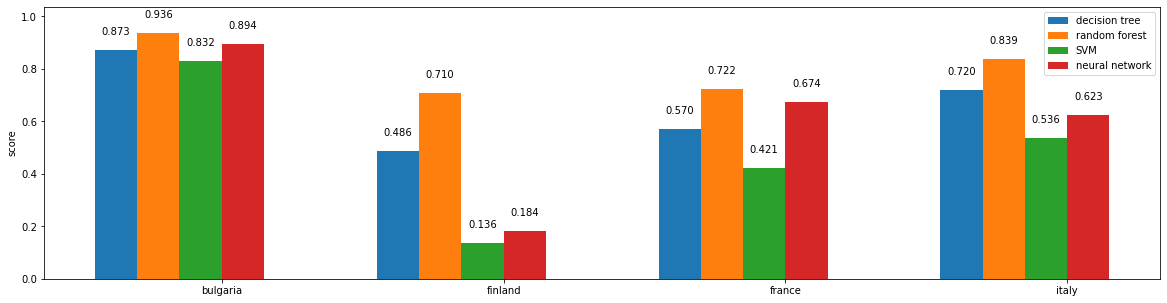

In [52]:
plot_score(regional_score, regional_label, model_label, 'score')

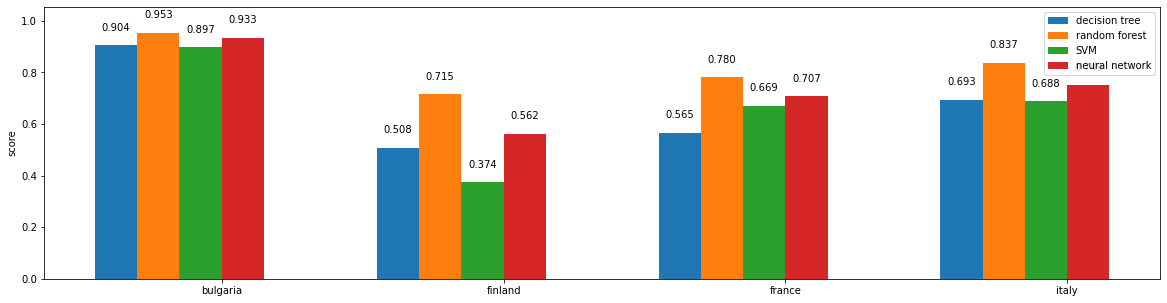

In [53]:
plot_score(regional_score_log, regional_label, model_label, 'score')

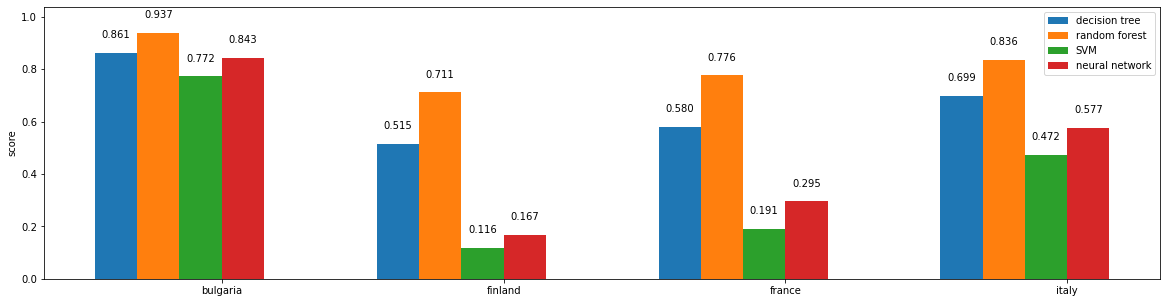

In [54]:
plot_score(all_score, regional_label, model_label, 'score')

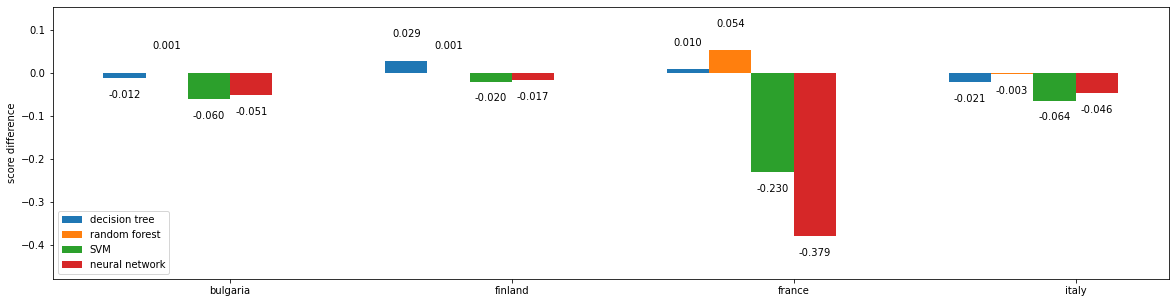

In [55]:
diff = all_score - regional_score
plot_score(diff, regional_label, model_label, 'score difference')

### Leave one region out

In [9]:
reg_idx = [0,1,2,3]
comb = combinations(reg_idx, 3)

for c in list(comb):
    X_train = []
    y_train = []
    for i in c:
        X_train.append(datas[i]['X'])
        y_train.append(datas[i]['y'])
        
    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)
    
    test_idx = list(set(reg_idx) - set(c))[0]
   
    X_test = datas[test_idx]['X']
    y_test = datas[test_idx]['y']
    
    rfr = RandomForestRegressor(random_state = 42)
    model = make_pipeline(scaler, rfr)
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print("Prediction of", datas[test_idx]['name'], "score: ", "{:.3f}".format(test_score))
    print('------------------------------')